In [1]:
import pandas as pd
import pymssql
from datetime import datetime, date 

import numpy as np
from numpy import log
from prophet import Prophet

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from prophet.plot import add_changepoints_to_plot
import itertools

import holidays
import time

import random
from IPython.display import clear_output
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import pickle

/home/aaqil/aaqil_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
def get_data():
    try:
        con = pymssql.connect(user='username',password = 'password'
                 ,host='server',database='db',autocommit = True)
    except Exception as e:
        print('unable to connnect',e)
    cur=con.cursor()
    
    query="""
            SELECT CONVERT(date, CP.DATE_ENTRY) as Date, COUNT(DISTINCT C.CLAIM_NO) as Claims,
        SUM(CP.AMOUNT_PAID)'PAYMENTS'
        FROM PATIENT AS P
        JOIN CLAIMS AS C ON P.PATIENT_ACCOUNT=C.PATIENT_ACCOUNT

AND ISNULL(C.DELETED,0)=0
        AND ISNULL(P.DELETED,0)=0
        JOIN CLAIM_PAYMENTS AS CP ON C.CLAIM_NO=CP.CLAIM_NO
        AND ISNULL(CP.DELETED,0)=0
        JOIN PRACTICES AS PR ON PR.PRACTICE_CODE=P.PRACTICE_CODE
        AND PR.IS_ACTIVE=1 AND ISNULL(PR.IS_TEST_PRACTICE,0)=0
        AND ISNULL(PR.EXCLUDE_FROM_BILLING_REPORTS,0) = 0
        AND PR.EMR_NAME NOT IN ('CHARTS PRO','PM STANDALONE','TESTINGPRACTICE')
        AND PR.PRACTICE_CODE NOT LIKE '9090%' AND PR.PRAC_NAME NOT LIKE '%TEST%'
        WHERE CONVERT(date, CP.DATE_ENTRY) BETWEEN  CONVERT(date, '01-01-2019')
        AND CONVERT(date, '10-20-2022')
        GROUP BY CONVERT(date, CP.DATE_ENTRY)
        ORDER BY CONVERT(date, CP.DATE_ENTRY) ASC
            """
     
    try:
        cur.execute(query)
        df=pd.DataFrame(cur.fetchall(),columns=[x[0] for x in cur.description])
        cur.close
        con.close
        return df
    except Exception as e:
        print('error in query',e)
        con.close()

In [3]:
df=get_data()

In [4]:
data=df.copy
df.columns
df.shape

(1389, 3)

In [5]:
df.head()

,Date,Claims,PAYMENTS
0,2019-01-01,15589,696717.6800
1,2019-01-02,25068,1133132.8630
2,2019-01-03,30796,1560087.9600
3,2019-01-04,32438,1605829.1200
4,2019-01-05,9597,429901.3300


In [6]:
df['Date']=pd.to_datetime(df['Date'])

In [7]:
claim_data=df[['Date','Claims']]

In [8]:
claim_data.Claims = claim_data.Claims.apply(int)

In [9]:
# df[['CHARGE_SUM']].apply(int)

In [10]:
claim_data.head()

,Date,Claims
0,2019-01-01,15589
1,2019-01-02,25068
2,2019-01-03,30796
3,2019-01-04,32438
4,2019-01-05,9597


In [11]:
claim_data = claim_data.rename(columns={'Date': 'ds','Claims': 'y'})

In [12]:
claim_data['ds'] = pd.DatetimeIndex(claim_data['ds'])

In [13]:
claim_data.set_index('ds',inplace=True)

In [14]:
train=claim_data.loc[:'09-30-2022']
test=claim_data.loc['10-01-2022':]

In [15]:
train.reset_index(inplace=True)
train.tail(10)

,ds,y
1359,2022-09-21,36154
1360,2022-09-22,26322
1361,2022-09-23,33414
1362,2022-09-24,22178
1363,2022-09-25,5373
1364,2022-09-26,19864
1365,2022-09-27,27398
1366,2022-09-28,26805
1367,2022-09-29,34576
1368,2022-09-30,40725


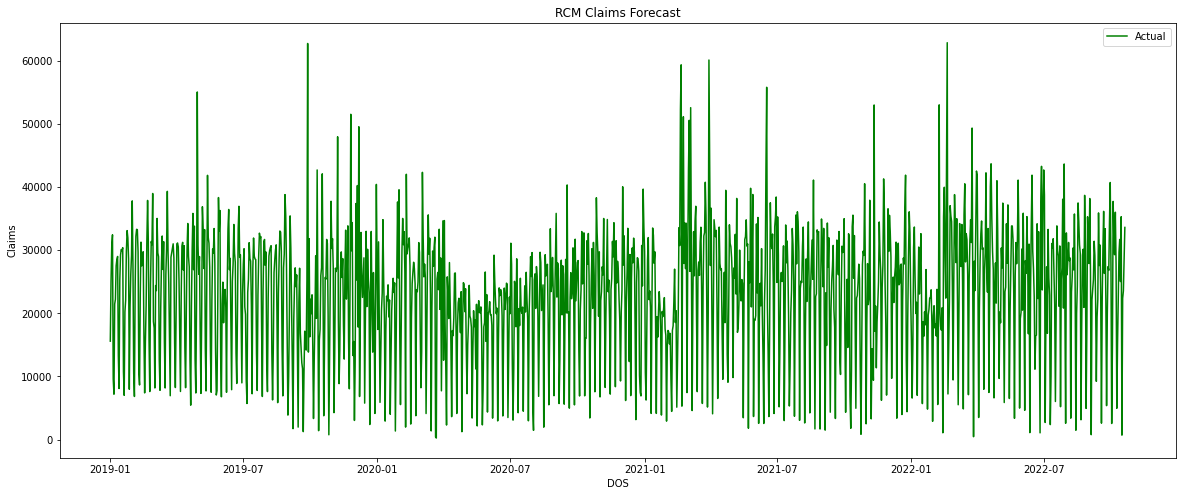

In [16]:
plt.rcParams["figure.figsize"] = (20,8)
plt.plot(claim_data
         ,color='g', label='Actual')
plt.xlabel("DOS")
plt.ylabel("Claims")
plt.title("RCM Claims Forecast")
plt.legend(loc='upper right')
plt.show()

In [17]:
holiday = pd.DataFrame([])
for date, name in sorted(holidays.UnitedStates(years=[2021,2022]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "US-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [18]:
test_fc=test.reset_index()
test_fc.head()

,ds,y
0,2022-10-01,27477
1,2022-10-02,2548
2,2022-10-03,14909
3,2022-10-04,37728
4,2022-10-05,31366


In [19]:
train_fc=train.set_index('ds')#.loc['01-01-2020':]
train_fc=train_fc.reset_index()
train_fc.head()

,ds,y
0,2019-01-01,15589
1,2019-01-02,25068
2,2019-01-03,30796
3,2019-01-04,32438
4,2019-01-05,9597


### Hyperparameter Tuning

In [20]:
my_model = Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=25,
    changepoint_range=0.8,
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality='auto',
    holidays=None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None,)

In [21]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[10,15,20],
              'n_changepoints' : [25,50,75,100,125]
              }
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 150


In [22]:
future_dates=pd.DataFrame(test_fc['ds'])
future_dates
model_parameters = pd.DataFrame(columns = ['mape','me','rmse','Parameters'])
cnt=1
for p in grid:
    clear_output(wait=True)
    print('Running at: ',cnt)
    cnt+=1
    test = pd.DataFrame()
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         holidays=holiday, 
#                          daily_seasonality=True,
#                          yearly_seasonality=True,
                         interval_width=0.95)
    train_model.add_country_holidays(country_name='US')
    train_model.fit(train)
    train_forecast = train_model.predict(future_dates)
    fc=train_forecast[['ds','yhat']]
    me = me = np.mean(fc.yhat - test_fc.y)
    mape=np.mean(np.abs(fc.yhat - test_fc.y)/np.abs(test_fc.y)) 
    rmse=rmse = np.mean((fc.yhat - test_fc.y)**2)**.5
    model_parameters = model_parameters.append({'mape':mape,'me':me,'rmse':rmse,'Parameters':p},ignore_index=True)
    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


Running at:  150


INFO:cmdstanpy:finish chain 1


In [23]:
md=model_parameters.copy()
md['me']=abs(md['me'])
md.sort_values(by=['rmse'],ascending=True).iloc[0]['Parameters']


{'changepoint_prior_scale': 0.1,
 'holidays_prior_scale': 20,
 'n_changepoints': 75,
 'seasonality_mode': 'multiplicative'}

In [24]:
#best rmse vale
{'changepoint_prior_scale': 0.1,
 'holidays_prior_scale': 20,
 'n_changepoints': 100,
 'seasonality_mode': 'multiplicative'}

#best mape value
{'changepoint_prior_scale': 0.5,
 'holidays_prior_scale': 10,
 'n_changepoints': 50,
 'seasonality_mode': 'additive'}

my_model1 = Prophet(changepoint_prior_scale = 0.1,
                     holidays_prior_scale = 20,
                     n_changepoints = 75,
                     seasonality_mode = 'multiplicative',
                     weekly_seasonality=True,
#                      daily_seasonality=True,
#                      yearly_seasonality=True,
                     holidays=holiday,
                     interval_width=0.95)

In [25]:
my_model1.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [26]:
filename = 'RCM_Prophet_Overall_Payments_Claims.sav'
pickle.dump(my_model1, open(filename, 'wb'))

loaded_model = pickle.load(open(filename, 'rb'))

date_range=pd.date_range(start = '09-01-2022', end = '09-20-2022')
future_dates=pd.DataFrame(date_range,columns=['ds'])


forecast_outsample = loaded_model.predict(future_dates)
forecast_outsample[['ds', 'yhat']].tail()

,ds,yhat
15,2022-09-16,30048.72485
16,2022-09-17,21523.83327
17,2022-09-18,3825.54981
18,2022-09-19,21150.41897
19,2022-09-20,28964.78203


In [27]:
test=claim_data.loc['09-01-2022':'10-20-2022']

future_dates=pd.DataFrame(test.reset_index()['ds'])
future_dates

date_range=pd.date_range(start = '10-01-2022', end = '03-15-2023')
fd=pd.DataFrame(date_range,columns=['ds'])
test.tail()

,y
ds,
2022-10-16,704
2022-10-17,22383
2022-10-18,23548
2022-10-19,28349
2022-10-20,33608


In [28]:
forecast_outsample = my_model1.predict(fd)
forecast_outsample[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(50)


,ds,yhat,yhat_lower,yhat_upper
0,2022-10-01,22422.33011,10528.00717,33676.69640
1,2022-10-02,4754.29595,-7173.89807,16746.64859
2,2022-10-03,22197.63205,10195.65527,33888.22058
3,2022-10-04,30082.97683,18330.85765,41699.45725
4,2022-10-05,31012.97562,19391.44958,42686.18978
5,2022-10-06,30652.93667,18953.18616,42062.91008
6,2022-10-07,31415.44520,20016.65840,42883.93499
7,2022-10-08,22917.47617,12269.95919,34464.66665
8,2022-10-09,5183.27529,-6514.23735,17246.80561
9,2022-10-10,20692.38454,7194.96563,32342.61319


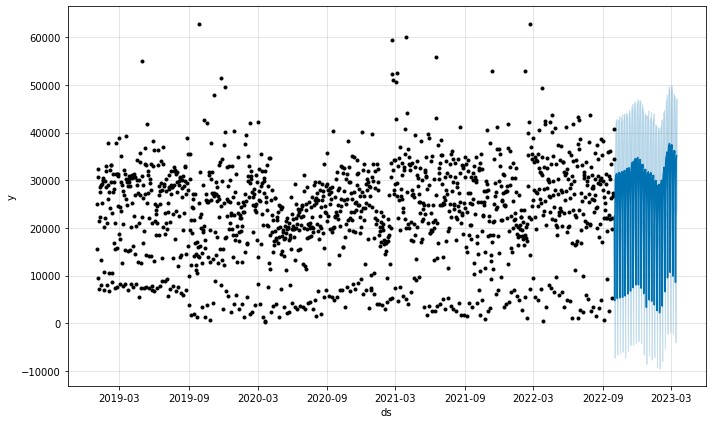

In [29]:
fig=my_model1.plot(forecast_outsample, uncertainty=True)

In [30]:
fc=forecast_outsample[['ds','yhat']]
fc.set_index('ds',inplace=True)
fc.head()

,yhat
ds,
2022-10-01,22422.33011
2022-10-02,4754.29595
2022-10-03,22197.63205
2022-10-04,30082.97683
2022-10-05,31012.97562


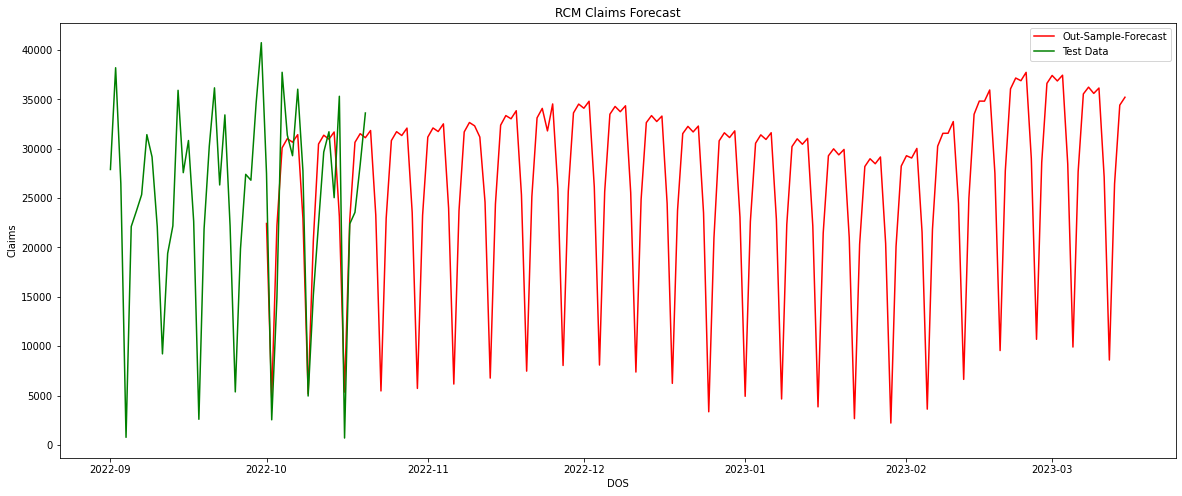

In [31]:
plt.rcParams["figure.figsize"] = (20,8)
#plt.plot(train.set_index('ds'),color='y', label='Train Data')
#plt.plot(tc,color='b', label='In-Sample-Forecast')
plt.plot(fc,color='r', label='Out-Sample-Forecast')
plt.plot(test,color='g', label='Test Data')
plt.xlabel("DOS")
plt.ylabel("Claims")
plt.title("RCM Claims Forecast")
plt.legend(loc='upper right')
plt.show()

In [32]:
# print('ME Out Sample Forecast: ',np.mean(fc.values-test.values))

# print('RMSE Out Sample Forecast: ',np.mean((fc.yhat - test.y)**2)**.5 )

# print('MAPE: ',np.mean(np.abs(fc.yhat - test.y)/np.abs(test.y)))

In [33]:
d=pd.merge(
    forecast_outsample[['ds', 'yhat']],
    test.reset_index(),
    how="left",
    on=['ds'],
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)
d['diff']=abs(d['yhat']-d['y'])
#d.to_csv('prophet.csv')
d.head(1000)

,ds,yhat,y,diff
0,2022-10-01,22422.33011,27477.00000,5054.66989
1,2022-10-02,4754.29595,2548.00000,2206.29595
2,2022-10-03,22197.63205,14909.00000,7288.63205
3,2022-10-04,30082.97683,37728.00000,7645.02317
4,2022-10-05,31012.97562,31366.00000,353.02438
...,...,...,...,...
161,2023-03-11,27127.34817,NaN,NaN
162,2023-03-12,8600.03044,NaN,NaN
163,2023-03-13,26434.12865,NaN,NaN
164,2023-03-14,34403.40826,NaN,NaN


In [34]:
predicted=d['yhat'].sum()
original=d['y'].sum()

print(predicted,original)


(original/predicted)*100
# (predicted/original)*100

4349079.304924279 479919.0


11.034956282738003

In [35]:
d.yhat = d.yhat.apply(int)

In [36]:
# def DUMP_DATA(d,forecast_section,pracice_code):
#     data_to_dump=d[['yhat','ds']]
#     data_to_dump['PRACTICE_CODE']=pracice_code
#     data_to_dump['FORECAST_TYPE']=forecast_section
#     data_to_dump.rename(columns={"yhat": "FORECASTED_VALUE", "ds": "FORECAST_DATE"},inplace=True)

#     con = pymssql.connect(user='mtbcweb',password = 'mtbcweb@mtbc'
#                          ,host='172.16.0.168',database='AmazingDb',autocommit = True)
#     cur=con.cursor()
#     for i, row in data_to_dump.iterrows():
#         query="""
#             insert into DS_RCM_Forecasting(practice_code,forecasted_value,Forecast_date,Forecast_section)
#         values(%s,%s,%s,%s)
#             """
#         cur.execute(query, (row['PRACTICE_CODE'],row['FORECASTED_VALUE'],row['FORECAST_DATE'],row['FORECAST_TYPE']))
#     print('Data Inserted')
#     con.close()

In [39]:
def DUMP_DATA(d,forecast_section,pracice_code):
    data_to_dump=d[['yhat','ds']]
    data_to_dump['PRACTICE_CODE']=pracice_code
    data_to_dump['FORECAST_TYPE']=forecast_section
    data_to_dump.rename(columns={"yhat": "FORECASTED_VALUE", "ds": "FORECAST_DATE"},inplace=True)

    con = pymssql.connect(user='datascience',password = 'mtbc@1234'
                         ,host='172.16.0.66',database='ds_test',autocommit = True)
    cur=con.cursor()
    for i, row in data_to_dump.iterrows():
        query="""
            insert into DS_RCM_Forecasting(practice_code,forecasted_value,Forecast_date,Forecast_section)
        values(%s,%s,%s,%s)
            """
        cur.execute(query, (row['PRACTICE_CODE'],row['FORECASTED_VALUE'],row['FORECAST_DATE'],row['FORECAST_TYPE']))
    print('Data Inserted')
    con.close()

In [40]:
DUMP_DATA(d,'Overall_Payments_Claims', 0)

Data Inserted
